In [1]:
import os
import time
from hydra_zen import instantiate, make_config, builds, to_yaml, load_from_yaml, launch
import sys
import pickle

from pathlib import Path

import jax.numpy as np
from jax import vmap, random, grad, jit
import jax.numpy.linalg as lin
from functools import partial
from tqdm import tqdm

from grassgp.grassmann import valid_grass_point, sample_karcher_mean, grass_dist, grass_exp, valid_grass_tangent, grass_log, convert_to_projs, compute_barycenter
from grassgp.means import zero_mean
from grassgp.kernels import rbf
from grassgp.models_optimised import GrassGP
from grassgp.plot_utils import flatten_samples, plot_grass_dists
from grassgp.utils import to_dictconf, get_save_path, vec, unvec
from grassgp.utils import safe_save_jax_array_dict as safe_save
from grassgp.utils import load_and_convert_to_samples_dict as load_data

import chex
from chex import assert_shape, assert_rank
from dataclasses import dataclass, field
from typing import Tuple, Union, Callable, Tuple

import numpyro
from numpyro.infer import SVI, Trace_ELBO, autoguide, init_to_value
import numpyro.distributions as dist

from grassgp.inference import run_inference

import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/yanni/.cache/pypoetry/virtualenvs/grassgp-JZ6xTmeL-py3.10/lib/python3.10/site-packages/jax/_src/deprecations.py:51: DeprecationWarning: jax.interpreters.xla.xla_call_p is deprecated. Please use jax.experimental.pjit.pjit_p instead.
  warnings.warn(message, DeprecationWarning)


In [2]:
xs = np.load("xs_matern.npz")

In [3]:
Ws = np.load("Ws_mater.npz")

In [4]:
assert vmap(lambda W: valid_grass_point(W[:,None]))(Ws.T).all()

In [5]:
i=0
W0 = Ws.T[i][:,None]

In [6]:
# dists = vmap(lambda W: grass_dist(W[:,None], W0))(Ws.T)

In [7]:
# plt.plot(xs,dists)
# plt.title(r"Grassmann distantance from $P(0)$")
# plt.xlabel(r"$x$")
# plt.grid()
# plt.show()

In [8]:
# angles = vmap(lambda W: np.arccos(np.inner(W0.flatten(),W)))(Ws.T)

In [9]:
# plt.plot(xs,angles)
# plt.title(r"Angle between $P(x)$ and $P(0)$")
# plt.xlabel(r"$x$")
# plt.grid()
# plt.show()

In [10]:
s_test = xs.copy()
Ws_test = Ws.T.copy()[:,:,None]
s_gap = 4
s_train = s_test[::s_gap].copy()
Ws_train = Ws_test[::s_gap,:,:].copy()

In [11]:
# plt.plot(s_test,dists)
# plt.scatter(s_train,dists[::s_gap])
# plt.grid()
# plt.show()

In [12]:
# anchors = []
# losses = []
# N_anchor_inits = 20
# keys = random.split(random.PRNGKey(2346),N_anchor_inits)
# for key in tqdm(keys):
#     mu_0 = rand_grass_point(key, 100, 1)
#     anchor, _, _ = sample_karcher_mean(Ws_train, start_ind = None, start_point=mu_0)
#     loss = vmap(lambda W: grass_dist(W,anchor)**2)(Ws_train).sum()
#     anchors.append(anchor)
#     losses.append(loss)

# anchors = np.array(anchors)
# losses = np.array(losses)

# Model

In [13]:
def run_svi_for_map(rng_key, model, maxiter, step_size, *args):
    start = time.time()
    guide = autoguide.AutoDelta(model)
    optimzer = numpyro.optim.Adam(step_size)
    svi = SVI(model, guide, optimzer, Trace_ELBO())
    svi_results = svi.run(rng_key, maxiter, *args)
    print('\nSVI elapsed time:', time.time() - start)
    return svi_results

In [14]:
# n_train = len(s_train)
# plt.scatter(range(n_train),s_train)
# plt.show()

In [15]:
anchor_point, _, _ = sample_karcher_mean(Ws_train)
assert valid_grass_point(anchor_point)

In [16]:
# compute log of training data
log_Ws_train = vmap(lambda W: grass_log(anchor_point, W))(Ws_train)

In [17]:
@jit
def invert_kron_plus_sigmaSq_eye(C: chex.ArrayDevice, R: chex.ArrayDevice, sigma: float) -> chex.ArrayDevice:
    Sc, Uc = lin.eigh(C)
    Sr, Ur = lin.eigh(R)
    
    diag_term = np.kron(Sc, Sr) + sigma**2
    diag_term_inv = np.diag(1/diag_term)
    
    inv = np.kron(Uc, Ur) @ diag_term_inv @ np.kron(Uc.T, Ur.T)
    return inv

In [18]:
@chex.dataclass
class FullMatGP:
    d_in: int
    d_out: Tuple[int, int]
    mu: Callable = field(repr=False)
    k: Callable = field(repr=False)
    Omega: chex.ArrayDevice = field(repr=False)
    cov_jitter: float = field(default=1e-8, repr=False)

    def __post_init__(self):
        d, n = self.d_out
        d_n = d * n
        assert_shape(self.Omega, (d_n, d_n),
                    custom_message=f"Omega has shape {self.Omega.shape}; expected shape {(d_n, d_n)}")

    def model(self, s: chex.ArrayDevice, use_kron_chol: bool = True) -> chex.ArrayDevice:
        d, n = self.d_out
        d_n = d * n
        assert_rank(s, self.d_in)
        N = s.shape[0]

        # compute mean matrix M = [mu(s[1]), mu(s[2]), ..., mu(s[N])]
        M = np.hstack(vmap(self.mu)(s))
        assert_shape(M, (d, n*N))

        # compute kernel matrix
        K = self.k(s, s)
        # cond_num = numpyro.deterministic("cond_num", lin.cond(K))
        assert_shape(K, (N, N))

        # compute covariance matrix and cholesky factor
        if use_kron_chol:
            Chol = kron_chol(K + self.cov_jitter * np.eye(N), self.Omega)
        else:
            Cov = np.kron(K + self.cov_jitter * np.eye(N), self.Omega)
            Chol = lin.cholesky(Cov)

        # sample vec_Vs
        # Z = numpyro.sample("Z", dist.MultivariateNormal(covariance_matrix=np.eye(N*d_n)))
        Z = numpyro.sample("Z", dist.Normal().expand([N*d_n]))
        vec_Vs = numpyro.deterministic("vec_Vs", vec(M) + Chol @ Z)

        # form Vs
        Vs = numpyro.deterministic("Vs", vmap(lambda params: unvec(params, d, n))(np.array(vec_Vs.split(N))))
        return Vs

    def sample(self, seed: int, s: chex.ArrayDevice) -> chex.ArrayDevice:
        model = self.model
        seeded_model = handlers.seed(model, rng_seed=seed)
        return seeded_model(s)

    def predict(self, key: chex.ArrayDevice, s_test: chex.ArrayDevice, s_train: chex.ArrayDevice, Vs_train: chex.ArrayDevice, jitter: float = 1e-8) -> Tuple[chex.ArrayDevice, chex.ArrayDevice]:
        d, n = self.d_out
        d_in = self.d_in
        d_n = d * n
        N_train = s_train.shape[0]
        N_test = s_test.shape[0]
        if d_in > 1:
            assert s_train.shape[1] == d_in
            assert s_test.shape[1] == d_in

        # compute means
        M_train = np.hstack(vmap(self.mu)(s_train))
        M_test = np.hstack(vmap(self.mu)(s_test))
        assert_shape(M_train, (d, n*N_train))
        assert_shape(M_test, (d, n*N_test))

        # compute kernels between train and test locs
        K_train_train = self.k(s_train, s_train)
        assert_shape(K_train_train, (N_train, N_train))
        K_train_test = self.k(s_train, s_test)
        assert_shape(K_train_test, (N_train, N_test))
        K_test_train = K_train_test.T
        K_test_test = self.k(s_test, s_test)
        assert_shape(K_test_test, (N_test, N_test))

        # compute posterior mean and cov
        K_test_train_Omega = np.kron(K_test_train, self.Omega)
        K_train_test_Omega = np.kron(K_train_test, self.Omega)
        K_test_test_Omega = np.kron(K_test_test, self.Omega)
        # FIX: change for singular Omega
        # print(f"Rank of Omega = {lin.matrix_rank(self.Omega)}. Shape of Omega = {self.Omega.shape}")
        # if lin.matrix_rank(self.Omega) == d_n:
        #     mean_sols = kron_solve(K_train_train, self.Omega, vec(np.hstack(Vs_train)) - vec(M_train))
        #     cov_sols = vmap(lambda v: kron_solve(K_train_train, self.Omega, v), in_axes=1, out_axes=1)(K_train_test_Omega)
        # else:
        #     K_train_train_inv = lin.inv(K_train_train)
        #     Omega_pinv = lin.pinv(self.Omega)
        #     K_train_train_Omega_pinv = np.kron(K_train_train_inv, Omega_pinv)
        #     mean_sols = K_train_train_Omega_pinv @ (vec(np.hstack(Vs_train)) - vec(M_train))
        #     cov_sols = K_train_train_Omega_pinv @ K_train_test_Omega
        K_train_train_inv = lin.inv(K_train_train)
        Omega_pinv = lin.pinv(self.Omega)
        K_train_train_Omega_pinv = np.kron(K_train_train_inv, Omega_pinv)
        mean_sols = K_train_train_Omega_pinv @ (vec(np.hstack(Vs_train)) - vec(M_train))
        cov_sols = K_train_train_Omega_pinv @ K_train_test_Omega
        
        vec_post_mean = vec(M_test) + K_test_train_Omega @ mean_sols
        assert_shape(vec_post_mean, (d*n*N_test,),
                     custom_message=f"vec_post_mean should have shape {(d*n*N_test,)}; obtained {vec_post_mean.shape}")

        # cov_sols = vmap(lambda v: kron_solve(K_train_train, self.Omega, v), in_axes=1, out_axes=1)(K_train_test_Omega)
        post_cov = K_test_test_Omega - K_test_train_Omega @ cov_sols
        assert_shape(post_cov, (d*n*N_test, d*n*N_test),
                     custom_message=f"post_cov should have shape {(d*n*N_test,d*n*N_test)}; obtained {post_cov.shape}")

        # sample predictions
        post_cov += jitter * np.eye(d*n*N_test)
        
        # FIX: change for singular post_cov
        # print(f"Rank of posterior cov = {lin.matrix_rank(post_cov)}. Shape of posterior cov = {post_cov.shape}")
        vec_pred = dist.MultivariateNormal(loc=vec_post_mean, covariance_matrix=post_cov).sample(key)
        assert_shape(vec_pred, (d*n*N_test,),
                     custom_message=f"vec_pred should have shape {(d*n*N_test,)}; obtained {vec_pred.shape}")

        # unvec mean and preds and return
        post_mean = vmap(lambda params: unvec(params, d, n))(np.array(vec_post_mean.split(N_test)))
        pred = vmap(lambda params: unvec(params, d, n))(np.array(vec_pred.split(N_test)))
        return post_mean, pred
    
    def predict_new(self, key: chex.ArrayDevice, s_test: chex.ArrayDevice, s_train: chex.ArrayDevice, Vs_train: chex.ArrayDevice, sigma: float, jitter: float = 1e-8) -> Tuple[chex.ArrayDevice, chex.ArrayDevice]:
        d, n = self.d_out
        d_in = self.d_in
        d_n = d * n
        N_train = s_train.shape[0]
        N_test = s_test.shape[0]
        if d_in > 1:
            assert s_train.shape[1] == d_in
            assert s_test.shape[1] == d_in

        # compute means
        M_train = np.hstack(vmap(self.mu)(s_train))
        M_test = np.hstack(vmap(self.mu)(s_test))
        assert_shape(M_train, (d, n*N_train))
        assert_shape(M_test, (d, n*N_test))

        # compute kernels between train and test locs
        K_train_train = self.k(s_train, s_train)
        assert_shape(K_train_train, (N_train, N_train))
        K_train_test = self.k(s_train, s_test)
        assert_shape(K_train_test, (N_train, N_test))
        K_test_train = K_train_test.T
        K_test_test = self.k(s_test, s_test)
        assert_shape(K_test_test, (N_test, N_test))

        if sigma != 0:
            K_test_train_Omega = np.kron(K_test_train, self.Omega)
            K_train_test_Omega = np.kron(K_train_test, self.Omega)
            K_test_test_Omega = np.kron(K_test_test, self.Omega)
            
            inv = invert_kron_plus_sigmaSq_eye(K_train_train, self.Omega, sigma)
            mean_sols = inv @ (vec(np.hstack(Vs_train)) - vec(M_train))
            cov_sols = inv @ K_train_test_Omega
            
            vec_post_mean = vec(M_test) + K_test_train_Omega @ mean_sols
            assert_shape(vec_post_mean, (d*n*N_test,),
                         custom_message=f"vec_post_mean should have shape {(d*n*N_test,)}; obtained {vec_post_mean.shape}")

            # cov_sols = vmap(lambda v: kron_solve(K_train_train, self.Omega, v), in_axes=1, out_axes=1)(K_train_test_Omega)
            post_cov = K_test_test_Omega - K_test_train_Omega @ cov_sols
            assert_shape(post_cov, (d*n*N_test, d*n*N_test),
                         custom_message=f"post_cov should have shape {(d*n*N_test,d*n*N_test)}; obtained {post_cov.shape}")
        else:
            K_train_train_inv = lin.inv(K_train_train)
            Omega_pinv = lin.pinv(self.Omega)
            
            mean_sol_mat = np.kron(K_test_train @ K_train_train_inv, self.Omega @ Omega_pinv)
            mean_sols = mean_sol_mat @ (vec(np.hstack(Vs_train)) - vec(M_train))
            vec_post_mean = vec(M_test) + mean_sols
            assert_shape(vec_post_mean, (d*n*N_test,),
                         custom_message=f"vec_post_mean should have shape {(d*n*N_test,)}; obtained {vec_post_mean.shape}")
            
            post_cov = np.kron(K_test_test - K_test_train @ K_train_train_inv @ K_train_test, self.Omega)
            assert_shape(post_cov, (d*n*N_test, d*n*N_test),
                         custom_message=f"post_cov should have shape {(d*n*N_test,d*n*N_test)}; obtained {post_cov.shape}")

        # sample predictions
        post_cov += jitter * np.eye(d*n*N_test)
        
        vec_pred = dist.MultivariateNormal(loc=vec_post_mean, covariance_matrix=post_cov).sample(key)
        assert_shape(vec_pred, (d*n*N_test,),
                     custom_message=f"vec_pred should have shape {(d*n*N_test,)}; obtained {vec_pred.shape}")

        # unvec mean and preds and return
        post_mean = vmap(lambda params: unvec(params, d, n))(np.array(vec_post_mean.split(N_test)))
        pred = vmap(lambda params: unvec(params, d, n))(np.array(vec_pred.split(N_test)))
        return post_mean, pred

In [19]:
@chex.dataclass
class MatGP:
    d_in: int
    d_out: Tuple[int, int]
    mu: Callable = field(repr=False)
    k: Callable = field(repr=False)
    Omega_diag_chol: chex.ArrayDevice = field(repr=False)
    cov_jitter: float = field(default=1e-8, repr=False)

    def __post_init__(self):
        d, n = self.d_out
        d_n = d * n
        assert_shape(self.Omega_diag_chol, (d_n,),
                    custom_message=f"Omega_diag_chol has shape {self.Omega_diag_chol.shape}; expected shape {(d_n,)}")

    def model(self, s: chex.ArrayDevice) -> chex.ArrayDevice:
        d, n = self.d_out
        d_n = d * n
        assert_rank(s, self.d_in)
        N = s.shape[0]

        # compute mean matrix M = [mu(s[1]), mu(s[2]), ..., mu(s[N])]
        M = np.hstack(vmap(self.mu)(s))
        assert_shape(M, (d, n*N))
        # ! TODO: check this out
        vec_M = vec(M)

        # compute kernel matrix
        K = self.k(s, s)
        assert_shape(K, (N, N))
            
        K_chol = lin.cholesky(K + self.cov_jitter * np.eye(N))
        # Omega_diag_chol = np.sqrt(self.Omega_diag)

        # sample vec_Vs
        # Z = numpyro.sample("Z", dist.MultivariateNormal(covariance_matrix=np.eye(N*d_n)))
        Z = numpyro.sample("Z", dist.Normal().expand([N*d_n]))
        unvec_Z = unvec(Z, d_n, N)
        # vec_Vs = numpyro.deterministic("vec_Vs", vec(M + np.einsum('i,ij->ij', self.Omega_diag_chol, unvec_Z @ K_chol.T)))
        vec_Vs = numpyro.deterministic("vec_Vs", vec_M + vec(np.einsum('i,ij->ij', self.Omega_diag_chol, unvec_Z @ K_chol.T)))

        # form Vs
        Vs = numpyro.deterministic("Vs", vmap(lambda params: unvec(params, d, n))(np.array(vec_Vs.split(N))))
        return Vs

    def sample(self, seed: int, s: chex.ArrayDevice) -> chex.ArrayDevice:
        model = self.model
        seeded_model = handlers.seed(model, rng_seed=seed)
        return seeded_model(s)

#     def predict(self, key: chex.ArrayDevice, s_test: chex.ArrayDevice, s_train: chex.ArrayDevice, Vs_train: chex.ArrayDevice, jitter: float = 1e-8) -> Tuple[chex.ArrayDevice, chex.ArrayDevice]:
#         # TODO optimise this further to take advantage of diag structure of Omega
#         d, n = self.d_out
#         d_in = self.d_in
#         N_train = s_train.shape[0]
#         N_test = s_test.shape[0]
#         if d_in > 1:
#             assert s_train.shape[1] == d_in
#             assert s_test.shape[1] == d_in

#         # compute means
#         M_train = np.hstack(vmap(self.mu)(s_train))
#         M_test = np.hstack(vmap(self.mu)(s_test))
#         assert_shape(M_train, (d, n*N_train))
#         assert_shape(M_test, (d, n*N_test))

#         # compute kernels between train and test locs
#         K_train_train = self.k(s_train, s_train)
#         assert_shape(K_train_train, (N_train, N_train))
#         K_train_test = self.k(s_train, s_test)
#         assert_shape(K_train_test, (N_train, N_test))
#         K_test_train = K_train_test.T
#         K_test_test = self.k(s_test, s_test)
#         assert_shape(K_test_test, (N_test, N_test))

#         # compute posterior mean and cov
#         Omega_diag = self.Omega_diag_chol ** 2
#         Omega = np.diag(Omega_diag)
#         K_test_train_Omega = np.kron(K_test_train, Omega)
#         K_train_test_Omega = np.kron(K_train_test, Omega)
#         K_test_test_Omega = np.kron(K_test_test, Omega)
#         mean_sols = kron_solve(K_train_train, Omega, vec(np.hstack(Vs_train)) - vec(M_train))
#         vec_post_mean = vec(M_test) + K_test_train_Omega @ mean_sols
#         assert_shape(vec_post_mean, (d*n*N_test,),
#                      custom_message=f"vec_post_mean should have shape {(d*n*N_test,)}; obtained {vec_post_mean.shape}")

#         cov_sols = vmap(lambda v: kron_solve(K_train_train, Omega, v), in_axes=1, out_axes=1)(K_train_test_Omega)
#         post_cov = K_test_test_Omega - K_test_train_Omega @ cov_sols
#         assert_shape(post_cov, (d*n*N_test, d*n*N_test),
#                      custom_message=f"post_cov should have shape {(d*n*N_test,d*n*N_test)}; obtained {post_cov.shape}")

#         # sample predictions
#         post_cov += jitter * np.eye(d*n*N_test)
#         vec_pred = dist.MultivariateNormal(loc=vec_post_mean, covariance_matrix=post_cov).sample(key)
#         assert_shape(vec_pred, (d*n*N_test,),
#                      custom_message=f"vec_pred should have shape {(d*n*N_test,)}; obtained {vec_pred.shape}")

#         # unvec mean and preds and return
#         post_mean = vmap(lambda params: unvec(params, d, n))(np.array(vec_post_mean.split(N_test)))
#         pred = vmap(lambda params: unvec(params, d, n))(np.array(vec_pred.split(N_test)))
#         return post_mean, pred



In [20]:
@chex.dataclass
class GrassGP:
    d_in: int
    d_out: Tuple[int, int]
    mu: Callable = field(repr=False)
    k: Callable = field(repr=False)
    Omega_diag_chol: chex.ArrayDevice = field(repr=False)
    U: chex.ArrayDevice
    cov_jitter: float = field(default=1e-4, repr=False)

    def __post_init__(self):
        d, n = self.d_out
        d_n = d * n
        assert_shape(self.Omega_diag_chol, (d_n,),
                    custom_message=f"Omega_diag_chol has shape {self.Omega_diag_chol.shape}; expected shape {(d_n,)}")
        assert_shape(self.U, (d, n),
                    custom_message=f"U has shape {self.U.shape}; expected shape {(d, n)}")
        tol = 1e-06
        # assert valid_grass_point(self.U), f"U is not a valid point on Grassmann manifold G({d},{n}) at tolerance level {tol = }"

    @property
    def V(self) -> MatGP:
        mat_gp = MatGP(d_in=self.d_in, d_out=self.d_out, mu=self.mu, k=self.k, Omega_diag_chol=self.Omega_diag_chol, cov_jitter=self.cov_jitter)
        return mat_gp

    def tangent_model(self, s: chex.ArrayDevice) -> chex.ArrayDevice:
        d, n = self.d_out
        N = s.shape[0]
        Vs = self.V.model(s)
        I_UUT = np.eye(d) - self.U @ self.U.T
        Deltas = numpyro.deterministic("Deltas", np.einsum('ij,ljk->lik', I_UUT, Vs))
        assert_shape(Deltas, (N, d, n),
                    custom_message=f"Deltas has shape {Deltas.shape}; expected shape {(N, d, n)}")
        return Deltas

    def sample_tangents(self, seed: int, s: chex.ArrayDevice) -> chex.ArrayDevice:
        tangent_model = self.tangent_model
        seeded_model = handlers.seed(tangent_model, rng_seed=seed)
        Deltas = seeded_model(s)
        assert vmap(lambda Delta: valid_grass_tangent(self.U, Delta))(Deltas).all()
        return Deltas

    def sample_grass(self, seed: int, s: chex.ArrayDevice, reortho: bool = False) -> chex.ArrayDevice:
        Deltas = self.sample_tangents(seed, s)
        Ws = convert_to_projs(Deltas, self.U, reorthonormalize=reortho)
        return Ws
    
    def predict_tangents(self, key: chex.ArrayDevice, s_test: chex.ArrayDevice, s_train: chex.ArrayDevice, Vs_train: chex.ArrayDevice, jitter: float = 1e-8) -> Tuple[chex.ArrayDevice, chex.ArrayDevice]:
        d, _ = self.d_out
        I_UUT = np.eye(d) - self.U @ self.U.T
        V_mu = lambda s: I_UUT @ self.mu(s)
        Omega = np.diag(self.Omega_diag_chol ** 2)
        V_Omega = I_UUT @ Omega @ I_UUT.T
        V = FullMatGP(d_in=self.d_in, d_out=self.d_out, mu=V_mu, k=self.k, Omega=V_Omega, cov_jitter=self.cov_jitter)
        Deltas_mean, Deltas_pred = V.predict(key, s_test, s_train, Vs_train, jitter=jitter)
        return Deltas_mean, Deltas_pred
    
    def predict_tangents_new(self, key: chex.ArrayDevice, s_test: chex.ArrayDevice, s_train: chex.ArrayDevice, Vs_train: chex.ArrayDevice, sigma: float, jitter: float = 1e-8) -> Tuple[chex.ArrayDevice, chex.ArrayDevice]:
        d, _ = self.d_out
        I_UUT = np.eye(d) - self.U @ self.U.T
        V_mu = lambda s: I_UUT @ self.mu(s)
        Omega = np.diag(self.Omega_diag_chol ** 2)
        V_Omega = I_UUT @ Omega @ I_UUT.T
        V = FullMatGP(d_in=self.d_in, d_out=self.d_out, mu=V_mu, k=self.k, Omega=V_Omega, cov_jitter=self.cov_jitter)
        Deltas_mean, Deltas_pred = V.predict_new(key, s_test, s_train, Vs_train, sigma, jitter=jitter)
        return Deltas_mean, Deltas_pred

    def predict_grass(self, key: chex.ArrayDevice, s_test: chex.ArrayDevice, s_train: chex.ArrayDevice, Vs_train: chex.ArrayDevice, jitter: float = 1e-8, reortho: bool = False) -> Tuple[chex.ArrayDevice, chex.ArrayDevice]:
        Deltas_mean, Deltas_pred = self.predict_tangents(key, s_test, s_train, Vs_train, jitter=jitter)
        Ws_mean = convert_to_projs(Deltas_mean, self.U, reorthonormalize=reortho)
        Ws_pred = convert_to_projs(Deltas_pred, self.U, reorthonormalize=reortho)
        return Ws_mean, Ws_pred

#     def predict_tangents(self, key: chex.ArrayDevice, s_test: chex.ArrayDevice, s_train: chex.ArrayDevice, Vs_train: chex.ArrayDevice, jitter: float = 1e-8) -> Tuple[chex.ArrayDevice, chex.ArrayDevice]:
#         d, _ = self.d_out
#         Vs_mean, Vs_pred = self.V.predict(key, s_test, s_train, Vs_train, jitter=jitter)
#         I_UUT = np.eye(d) - self.U @ self.U.T
#         Deltas_mean = np.einsum('ij,ljk->lik', I_UUT, Vs_mean)
#         Deltas_pred = np.einsum('ij,ljk->lik', I_UUT, Vs_pred)
#         return Deltas_mean, Deltas_pred

#     def predict_grass(self, key: chex.ArrayDevice, s_test: chex.ArrayDevice, s_train: chex.ArrayDevice, Vs_train: chex.ArrayDevice, jitter: float = 1e-8, reortho: bool = False) -> Tuple[chex.ArrayDevice, chex.ArrayDevice]:
#         Deltas_mean, Deltas_pred = self.predict_tangents(key, s_test, s_train, Vs_train, jitter=jitter)
#         Ws_mean = convert_to_projs(Deltas_mean, self.U, reorthonormalize=reortho)
#         Ws_pred = convert_to_projs(Deltas_pred, self.U, reorthonormalize=reortho)
#         return Ws_mean, Ws_pred

In [21]:
log_Ws_test = vmap(lambda W: grass_log(anchor_point, W))(Ws_test)

In [22]:
@dataclass
class Model:
    name: str
    anchor_point: list
    d_in: int
    Omega_diag_chol: Union[list, None]
    k_include_noise: bool
    var: Union[float, None]
    length: Union[float, None]
    noise: Union[float, None]
    require_noise: bool
    jitter: float
    cov_jitter: float
    L_jitter: float
    reorthonormalize: bool
    b: float
    ell: float
    savvas_param: bool
    s_train: list
    s_test: list
    Ws_train: list
    Ws_test: list
    
    def model(self, s, log_Ws):
        U = np.array(self.anchor_point)
        d, n = U.shape
        N = s.shape[0]
        d_n = d * n
        # N_params = N * d_n
        if log_Ws is not None:
            assert log_Ws.shape == (N, d, n)

        # get/sample Omega
        if self.Omega_diag_chol is None:
            Omega_diag_chol = numpyro.sample('Omega_diag_chol', dist.LogNormal(0.0, 1.0).expand([d_n]))
        else:
            Omega_diag_chol = np.array(self.Omega_diag_chol)

        # get/sample kernel params
        if self.var is None:
            # sample var
            var = numpyro.sample("kernel_var", dist.LogNormal(0.0, self.b))
        else:
            var = self.var

        if self.length is None:
            # sample length
            if self.savvas_param:
                length = numpyro.sample("kernel_length", dist.LogNormal(-0.7, self.b))
            else:
                length = numpyro.sample("kernel_length", dist.LogNormal(0.0, self.b))
        else:
            length = self.length

        if self.require_noise:
            if self.noise is None:
                # sample noise
                noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, self.b))
            else:
                noise = self.noise
        else:
            noise = 0.0

        if self.savvas_param:
            kernel_params = {'var': var, 'length': np.sqrt(1 / length), 'noise': noise}
        else:
            kernel_params = {'var': var, 'length': length, 'noise': noise}
        
        # create kernel function
        k = lambda t, s: rbf(t, s, kernel_params, jitter=self.jitter, include_noise=self.k_include_noise)
        # create mean function
        mu = lambda s: zero_mean(s, d, n)

        # initialize GrassGP
        grass_gp = GrassGP(d_in=self.d_in, d_out=(d,n), mu=mu, k=k, Omega_diag_chol=Omega_diag_chol, U=U, cov_jitter=self.cov_jitter)

        # sample Deltas
        Deltas = grass_gp.tangent_model(s)

        # # # # ! check what power this should be
        # likelihood
        ell = self.ell
        with numpyro.plate("N", N):
            numpyro.sample("log_W", dist.continuous.MatrixNormal(loc=Deltas, scale_tril_row=ell * np.eye(d),scale_tril_column=np.eye(n)), obs=log_Ws)

In [37]:
TangentSpaceModelConf = builds(Model, populate_full_signature=True)

my_model_conf = TangentSpaceModelConf(
    name = "My Model",
    anchor_point = anchor_point.tolist(),
    d_in = 1,
    Omega_diag_chol = None,
    k_include_noise= True,
    var = 1.0,
    length = None,
    noise = None,
    require_noise = False,
    jitter = 1e-06,
    cov_jitter = 1e-4,
    L_jitter = 1e-8,
    reorthonormalize = False,
    b = 0.5,
    ell = 0.01,
    savvas_param = False,
    s_train = s_train.tolist(),
    s_test = s_test.tolist(),
    Ws_train = Ws_train.tolist(),
    Ws_test = Ws_test.tolist()
)

SVIConfig = make_config(
    seed = 123514354575,
    maxiter = 15000,
    step_size = 0.001
)

TrainConfig = make_config(
    seed = 9870687,
    n_warmup = 5000,
    n_samples = 7000,
    n_chains = 1,
    n_thinning = 2
)

PredictConfig = make_config(
    seed = 6578,
    splits = 25
)

PlotsConfig = make_config(
    acf_lags = 100,
    plot = True,
)

Config = make_config(
    model = my_model_conf,
    svi = SVIConfig,
    train = TrainConfig,
    predict = PredictConfig,
    plots = PlotsConfig,
    save_results = True,
    save_stdout = True,
    load_saved = False,
)

In [38]:
# numpyro.render_model(instantiate(Config.model).model, model_args=(s_train, log_Ws_train))

In [39]:
def pickle_save(obj, name: str):
    with open(name, 'wb') as f:
        pickle.dump(obj, f)

In [40]:
def pickle_load(name: str):
    with open(name, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [41]:
def train(cfg):
    # instantiate grass model
    model = instantiate(cfg.model).model
    
    save_results = cfg.save_results
    plot_figs = cfg.plots.plot
    save_stdout = cfg.save_stdout
    
    anchor_point = np.array(cfg.model.anchor_point)
    s_train = np.array(cfg.model.s_train)
    Ws_train = np.array(cfg.model.Ws_train)
    s_test = np.array(cfg.model.s_test)
    Ws_test = np.array(cfg.model.Ws_test)
    
    log_Ws_train = vmap(lambda W: grass_log(anchor_point, W))(Ws_train)
    log_Ws_test = vmap(lambda W: grass_log(anchor_point, W))(Ws_test)
        
    if save_results:
        training_test_data = {'s_train': s_train, 's_test': s_test, 'Ws_train': Ws_train, 'Ws_test': Ws_test, 'log_Ws_train': log_Ws_train, 'log_Ws_test': log_Ws_test, 'anchor_point': anchor_point}
        pickle_save(training_test_data, 'training_test_data.pickle')
    
    # run SVI to get MAP esimtate to initialise MCMC
    svi_key = random.PRNGKey(cfg.svi.seed)
    maxiter = cfg.svi.maxiter
    step_size = cfg.svi.step_size
    print("Running SVI for MAP estimate to initialise MCMC")
    svi_results = run_svi_for_map(svi_key, model, maxiter, step_size, s_train, log_Ws_train)
    
    if save_results:
        pickle_save(svi_results, 'svi_results.pickle')
    
    if plot_figs:
        # plot svi losses
        plt.plot(svi_results.losses)
        plt.show()
        
    # get initialisation from SVI results
    map_est = svi_results.params
    strip_val = len('_auto_loc')
    init_values = {key[:-strip_val]:value for (key, value) in map_est.items()}
    
    # run HMC
    train_key = random.PRNGKey(cfg.train.seed)
    mcmc_config = {'num_warmup' : cfg.train.n_warmup, 'num_samples' : cfg.train.n_samples, 'num_chains' : cfg.train.n_chains, 'thinning' : cfg.train.n_thinning, 'init_strategy' : init_to_value(values=init_values)}
    print("HMC starting.")
    mcmc = run_inference(train_key, mcmc_config, model, s_train, log_Ws_train)
    
    if save_stdout:
        original_stdout = sys.stdout
        with open('hmc_log.txt', 'w') as f:
            sys.stdout = f
            mcmc.print_summary()
            sys.stdout = original_stdout
    
    samples = mcmc.get_samples()
    inference_data = samples.copy()
    for param, initial_val in init_values.items():
        inference_data[f"{param}-initial_value"] = initial_val
    
    if save_results:
        pickle_save(inference_data, "inference_data.pickle")

In [42]:
# assert (vmap(lambda i: vmap(valid_grass_point)(Ws_means[i]))(np.arange(Ws_means.shape[0]))).all()
# assert (vmap(lambda i: vmap(lambda W: valid_grass_point(W, tol=1e-02))(Ws_preds[i]))(np.arange(Ws_preds.shape[0]))).all()

In [43]:
# train(Config)

In [44]:
# def predict_tangents(
#     key: chex.ArrayDevice,
#     s_test: chex.ArrayDevice,
#     s_train: chex.ArrayDevice,
#     Vs_train: chex.ArrayDevice,
#     cfg,
#     samples: dict,
#     n_samples: Union[int,None] = None,
#     jitter: float = 1e-8
# ) -> Tuple[chex.ArrayDevice, chex.ArrayDevice]:
    
#     d_in = cfg.model.d_in
#     U = np.array(cfg.model.anchor_point)
#     d, n = U.shape
#     cov_jitter = cfg.model.cov_jitter
#     k_include_noise = cfg.model.k_include_noise
#     kern_jitter = cfg.model.jitter
#     if n_samples is None:
#         n_samples = cfg.train.n_samples // cfg.train.n_thinning
#         assert n_samples == samples['Deltas'].shape[0]
    
#     def predict(
#         key: chex.ArrayDevice,
#         Omega_diag_chol: chex.ArrayDevice,
#         var: float,
#         length: float,
#         noise: float,
#     ) -> Tuple[chex.ArrayDevice, chex.ArrayDevice]:
#         # iniatilize GrassGP
#         kernel_params = {'var': var, 'length': length, 'noise': noise}
#         k = lambda t, s: rbf(t, s, kernel_params, jitter=kern_jitter, include_noise=k_include_noise)
#         mu = lambda s: zero_mean(s, d, n)
#         grass_gp = GrassGP(d_in=d_in, d_out=(d, n), mu=mu, k=k, Omega_diag_chol=Omega_diag_chol, U=U, cov_jitter=cov_jitter)

#         # predict
#         Deltas_mean, Deltas_pred = grass_gp.predict_tangents(key, s_test, s_train, Vs_train, jitter=jitter)
#         return Deltas_mean, Deltas_pred

#     # initialize vmap args
#     vmap_args = (random.split(key, n_samples),)
    
#     cfg_Omega_diag_chol = cfg.model.Omega_diag_chol
#     cfg_var = cfg.model.var
#     cfg_length = cfg.model.length
#     cfg_noise = cfg.model.noise
#     cfg_require_noise = cfg.model.require_noise
    
#     if cfg_Omega_diag_chol is None:
#         vmap_args += (samples['Omega_diag_chol'],)
#     else:
#         cfg_Omega_diag_chol = np.array(cfg_Omega_diag_chol)
#         vmap_args += (np.repeat(cfg_Omega_diag_chol[None,:,:], n_samples, axis=0),)
    
#     if cfg_var is None:
#         vmap_args += (samples['kernel_var'],)
#     else:
#         vmap_args += (cfg_var * np.ones(n_samples),)
        
#     if cfg_length is None:
#         vmap_args += (samples['kernel_length'],)
#     else:
#         vmap_args += (cfg_length * np.ones(n_samples),)
        
#     if cfg_require_noise:
#         if cfg_noise is None:
#             vmap_args += (samples['kernel_noise'],)
#         else:
#             vmap_args += (cfg_noise * np.ones(n_samples),)
#     else:
#         vmap_args += (np.zeros(n_samples),)
    
#     assert len(vmap_args) == 5
#     # Deltas_means, Deltas_preds = vmap(predict)(*vmap_args)
#     Deltas_means = []
#     Deltas_preds = []
#     for i in tqdm(range(n_samples)):
#         rand_key = vmap_args[0][i]
#         Omega_diag_chol = vmap_args[1][i]
#         var = vmap_args[2][i]
#         length = vmap_args[3][i]
#         noise = vmap_args[4][i]
#         mean, pred = predict(rand_key, Omega_diag_chol, var, length, noise)
#         Deltas_means.append(mean)
#         Deltas_preds.append(pred)
    
#     Deltas_means = np.array(Deltas_means)
#     Deltas_preds = np.array(Deltas_preds)
#     return Deltas_means, Deltas_preds

In [45]:
def predict_tangents(
    key: chex.ArrayDevice,
    s_test: chex.ArrayDevice,
    s_train: chex.ArrayDevice,
    Vs_train: chex.ArrayDevice,
    cfg,
    samples: dict,
    n_samples: Union[int,None] = None,
    jitter: float = 1e-8
) -> Tuple[chex.ArrayDevice, chex.ArrayDevice]:
    
    d_in = cfg.model.d_in
    U = np.array(cfg.model.anchor_point)
    d, n = U.shape
    cov_jitter = cfg.model.cov_jitter
    k_include_noise = cfg.model.k_include_noise
    kern_jitter = cfg.model.jitter
    if n_samples is None:
        n_samples = cfg.train.n_samples // cfg.train.n_thinning
        assert n_samples == samples['Deltas'].shape[0]
    
    def predict(
        key: chex.ArrayDevice,
        Omega_diag_chol: chex.ArrayDevice,
        var: float,
        length: float,
        noise: float,
    ) -> Tuple[chex.ArrayDevice, chex.ArrayDevice]:
        # iniatilize GrassGP
        kernel_params = {'var': var, 'length': length, 'noise': noise}
        k = lambda t, s: rbf(t, s, kernel_params, jitter=kern_jitter, include_noise=k_include_noise)
        mu = lambda s: zero_mean(s, d, n)
        grass_gp = GrassGP(d_in=d_in, d_out=(d, n), mu=mu, k=k, Omega_diag_chol=Omega_diag_chol, U=U, cov_jitter=cov_jitter)

        # predict
        Deltas_mean, Deltas_pred = grass_gp.predict_tangents_new(key, s_test, s_train, Vs_train, cfg.model.ell, jitter=jitter)
        return Deltas_mean, Deltas_pred

    # initialize vmap args
    vmap_args = (random.split(key, n_samples),)
    
    cfg_Omega_diag_chol = cfg.model.Omega_diag_chol
    cfg_var = cfg.model.var
    cfg_length = cfg.model.length
    cfg_noise = cfg.model.noise
    cfg_require_noise = cfg.model.require_noise
    
    if cfg_Omega_diag_chol is None:
        vmap_args += (samples['Omega_diag_chol'],)
    else:
        cfg_Omega_diag_chol = np.array(cfg_Omega_diag_chol)
        vmap_args += (np.repeat(cfg_Omega_diag_chol[None,:,:], n_samples, axis=0),)
    
    if cfg_var is None:
        vmap_args += (samples['kernel_var'],)
    else:
        vmap_args += (cfg_var * np.ones(n_samples),)
        
    if cfg_length is None:
        vmap_args += (samples['kernel_length'],)
    else:
        vmap_args += (cfg_length * np.ones(n_samples),)
        
    if cfg_require_noise:
        if cfg_noise is None:
            vmap_args += (samples['kernel_noise'],)
        else:
            vmap_args += (cfg_noise * np.ones(n_samples),)
    else:
        vmap_args += (np.zeros(n_samples),)
    
    assert len(vmap_args) == 5
    # Deltas_means, Deltas_preds = vmap(predict)(*vmap_args)
    Deltas_means = []
    Deltas_preds = []
    for i in tqdm(range(n_samples)):
        rand_key = vmap_args[0][i]
        Omega_diag_chol = vmap_args[1][i]
        var = vmap_args[2][i]
        length = vmap_args[3][i]
        noise = vmap_args[4][i]
        mean, pred = predict(rand_key, Omega_diag_chol, var, length, noise)
        Deltas_means.append(mean)
        Deltas_preds.append(pred)
    
    Deltas_means = np.array(Deltas_means)
    Deltas_preds = np.array(Deltas_preds)
    return Deltas_means, Deltas_preds

In [46]:
# def predict_grass(
#     key: chex.ArrayDevice,
#     s_test: chex.ArrayDevice,
#     s_train: chex.ArrayDevice,
#     Vs_train: chex.ArrayDevice,
#     cfg,
#     samples: dict,
#     jitter: float = 1e-8,
#     reortho: bool = False
# ) -> Tuple[chex.ArrayDevice, chex.ArrayDevice]:
    
#     d_in = cfg.model.d_in
#     U = np.array(cfg.model.anchor_point)
#     d, n = U.shape
#     cov_jitter = cfg.model.cov_jitter
#     k_include_noise = cfg.model.k_include_noise
#     kern_jitter = cfg.model.jitter
#     n_samples = cfg.train.n_samples // cfg.train.n_thinning
#     assert n_samples == samples['Deltas'].shape[0]
    
#     def predict(
#         key: chex.ArrayDevice,
#         Omega_diag_chol: chex.ArrayDevice,
#         var: float,
#         length: float,
#         noise: float,
#     ) -> Tuple[chex.ArrayDevice, chex.ArrayDevice]:
#         # iniatilize GrassGP
#         kernel_params = {'var': var, 'length': length, 'noise': noise}
#         k = lambda t, s: rbf(t, s, kernel_params, jitter=kern_jitter, include_noise=k_include_noise)
#         mu = lambda s: zero_mean(s, d, n)
#         grass_gp = GrassGP(d_in=d_in, d_out=(d, n), mu=mu, k=k, Omega_diag_chol=Omega_diag_chol, U=U, cov_jitter=cov_jitter)

#         # predict
#         Ws_mean, Ws_pred = grass_gp.predict_grass(key, s_test, s_train, Vs_train, jitter=jitter, reortho=reortho)
#         return Ws_mean, Ws_pred

#     # initialize vmap args
#     vmap_args = (random.split(key, n_samples),)
    
#     cfg_Omega_diag_chol = cfg.model.Omega_diag_chol
#     cfg_var = cfg.model.var
#     cfg_length = cfg.model.length
#     cfg_noise = cfg.model.noise
#     cfg_require_noise = cfg.model.require_noise
    
#     if cfg_Omega_diag_chol is None:
#         vmap_args += (samples['Omega_diag_chol'],)
#     else:
#         cfg_Omega_diag_chol = np.array(cfg_Omega_diag_chol)
#         vmap_args += (np.repeat(cfg_Omega_diag_chol[None,:,:], n_samples, axis=0),)
    
#     if cfg_var is None:
#         vmap_args += (samples['kernel_var'],)
#     else:
#         vmap_args += (cfg_var * np.ones(n_samples),)
        
#     if cfg_length is None:
#         vmap_args += (samples['kernel_length'],)
#     else:
#         vmap_args += (cfg_length * np.ones(n_samples),)
        
#     if cfg_require_noise:
#         if cfg_noise is None:
#             vmap_args += (samples['kernel_noise'],)
#         else:
#             vmap_args += (cfg_noise * np.ones(n_samples),)
#     else:
#         vmap_args += (np.zeros(n_samples),)
    
#     assert len(vmap_args) == 5
#     # Ws_means, Ws_preds = vmap(predict)(*vmap_args)
#     Ws_means = []
#     Ws_preds = []
#     for i in tqdm(range(n_samples)):
#         rand_key = vmap_args[0][i]
#         Omega_diag_chol = vmap_args[1][i]
#         var = vmap_args[2][i]
#         length = vmap_args[3][i]
#         noise = vmap_args[4][i]
#         mean, pred = predict(rand_key, Omega_diag_chol, var, length, noise)
#         Ws_means.append(mean)
#         Ws_preds.append(pred)
    
#     Ws_means = np.array(Ws_means)
#     Ws_preds = np.array(Ws_preds)
#     return Ws_means, Ws_preds

In [47]:
def analyse(cfg):
    # instantiate grass model
    model = instantiate(cfg.model).model
    
    save_results = cfg.save_results
    plot_figs = cfg.plots.plot
    save_stdout = cfg.save_stdout
    
    anchor_point = np.array(cfg.model.anchor_point)
    s_train = np.array(cfg.model.s_train)
    Ws_train = np.array(cfg.model.Ws_train)
    s_test = np.array(cfg.model.s_test)
    Ws_test = np.array(cfg.model.Ws_test)
    
    log_Ws_train = vmap(lambda W: grass_log(anchor_point, W))(Ws_train)
    log_Ws_test = vmap(lambda W: grass_log(anchor_point, W))(Ws_test)
    
    inference_data = pickle_load("inference_data.pickle")
    samples = dict(filter(lambda elem: 'initial_value' not in elem[0], inference_data.items()))
    initial_values = dict(filter(lambda elem: 'initial_value' in elem[0], inference_data.items()))
    assert set(samples.keys()).union(initial_values.keys()) == set(inference_data.keys())
    
    if plot_figs:
        my_samples = flatten_samples(samples, ignore=[])
        trace_plot_vars = ['kernel_length']
        # for key in my_samples.keys():
        #     if 'Omega' in key:
        #         trace_plot_vars.append(key)
        #     if 'sigmas' in key:
        #         trace_plot_vars.append(key)

        my_samples[trace_plot_vars].plot(subplots=True, figsize=(10,6), sharey=False)
        plt.show()

        for var in trace_plot_vars:
            sm.graphics.tsa.plot_acf(my_samples[var], lags=Config.plots.acf_lags)
            plt.title(f"acf for {var}")
            plt.show()
            
        trace_plot_vars = []
        for name in my_samples.columns:
            if "Omega" in name:
                trace_plot_vars.append(name)
                
        my_samples.plot(y=trace_plot_vars,legend=False,alpha=0.75)
        plt.show()

    # compute Ws's from mcmc samples
    tol=1e-5
    samples_Ws_train = vmap(lambda Deltas: convert_to_projs(Deltas, anchor_point, reorthonormalize=False))(samples['Deltas'])
    for ws in samples_Ws_train:
        assert vmap(lambda w: valid_grass_point(w, tol=tol))(ws).all()
        
    if save_results:
        pickle_save(samples_Ws_train, "samples_Ws_train.pickle")
        
    mcmc_barycenters = []
    for i in tqdm(range(s_train.shape[0])):
        points = samples_Ws_train[:,i,:,:]
        barycenter, _, _ = sample_karcher_mean(points)
        mcmc_barycenters.append(barycenter)
        
    mcmc_barycenters = np.array(mcmc_barycenters)
    
    if save_results:
        pickle_save(mcmc_barycenters, "mcmc_barycenters.pickle")
    
    in_sample_errors = vmap(grass_dist)(Ws_train, mcmc_barycenters)
    
    if plot_figs:
        plt.plot(s_train,in_sample_errors)
        plt.show()
    
    sd_s_train = []
    for i in tqdm(range(s_train.shape[0])):
        fixed = mcmc_barycenters[i]
        dists = vmap(lambda W: grass_dist(W, fixed))(samples_Ws_train[:,i,:,:])
        dists_Sq = dists**2
        sd_s_train.append(np.sqrt(dists_Sq.mean()))
    sd_s_train = np.array(sd_s_train)
    
    pd_data = {'s': s_train, 'errors': in_sample_errors, 'sd': sd_s_train}
    in_sample_errors_df = pd.DataFrame(data=pd_data)
    
    if save_results:
        pickle_save(in_sample_errors_df, "in_sample_errors_df.pickle")
    
    print("Prediction starting")
    pred_key = random.PRNGKey(cfg.predict.seed)
    Deltas_means, Deltas_preds = predict_tangents(pred_key, s_test, s_train, log_Ws_train, cfg, samples)
    assert np.isnan(Deltas_means).sum() == 0
    assert np.isnan(Deltas_preds).sum() == 0
    
    if save_results:
        pickle_save(Deltas_means, "Deltas_means.pickle")
        pickle_save(Deltas_preds, "Deltas_preds.pickle")
    
    Ws_means = vmap(lambda i: convert_to_projs(Deltas_means[i], anchor_point, reorthonormalize=cfg.model.reorthonormalize))(np.arange(Deltas_means.shape[0]))
    Ws_preds = vmap(lambda i: convert_to_projs(Deltas_preds[i], anchor_point, reorthonormalize=cfg.model.reorthonormalize))(np.arange(Deltas_preds.shape[0]))
    assert np.isnan(Ws_means).sum() == 0
    assert np.isnan(Ws_preds).sum() == 0
    
    if save_results:
        pickle_save(Ws_means, "Ws_means.pickle")
        pickle_save(Ws_preds, "Ws_preds.pickle")
    
    test_means_mcmc_barycenters = []
    for i in tqdm(range(s_test.shape[0])):
        points = Ws_means[:,i,:,:]
        barycenter, _, _ = sample_karcher_mean(points)
        test_means_mcmc_barycenters.append(barycenter)
        
    test_preds_mcmc_barycenters = []
    for i in tqdm(range(s_test.shape[0])):
        points = Ws_preds[:,i,:,:]
        barycenter, _, _ = sample_karcher_mean(points)
        test_preds_mcmc_barycenters.append(barycenter)
        
    test_means_mcmc_barycenters = np.array(test_means_mcmc_barycenters)
    test_preds_mcmc_barycenters = np.array(test_preds_mcmc_barycenters)
    
    if save_results:
        pickle_save(test_means_mcmc_barycenters, "test_means_mcmc_barycenters.pickle")
        pickle_save(test_preds_mcmc_barycenters, "test_preds_mcmc_barycenters.pickle")
    
    out_sample_mean_errors = vmap(grass_dist)(Ws_test, test_means_mcmc_barycenters)
    out_sample_pred_errors = vmap(grass_dist)(Ws_test, test_preds_mcmc_barycenters)
    
    if plot_figs:
        plt.plot(s_test,out_sample_mean_errors, label='error using means')
        plt.plot(s_test,out_sample_pred_errors, label='error using preds')
        plt.vlines(s_train, 0, 1, colors="green", linestyles="dashed")
        plt.legend()
        plt.show()
        
    sd_s_test_means = []
    for i in tqdm(range(s_test.shape[0])):
        fixed = test_preds_mcmc_barycenters[i]
        dists = vmap(lambda W: grass_dist(W, fixed))(Ws_means[:,i,:,:])
        dists_Sq = dists**2
        sd_s_test_means.append(np.sqrt(dists_Sq.mean()))
        
    sd_s_test_preds = []
    for i in tqdm(range(s_test.shape[0])):
        fixed = test_preds_mcmc_barycenters[i]
        dists = vmap(lambda W: grass_dist(W, fixed))(Ws_preds[:,i,:,:])
        dists_Sq = dists**2
        sd_s_test_preds.append(np.sqrt(dists_Sq.mean()))
    
    sd_s_test_means = np.array(sd_s_test_means)
    sd_s_test_preds = np.array(sd_s_test_preds)
    
    test_pd_data = {'s': s_test, 'errors_mean': out_sample_mean_errors, 'errors_pred': out_sample_pred_errors, 'sd_mean': sd_s_test_means, 'sd_pred': sd_s_test_preds}
    out_sample_errors_df = pd.DataFrame(data=test_pd_data)
    
    if save_results:
        pickle_save(out_sample_errors_df, "out_sample_errors_df.pickle")

In [48]:
# analyse(Config)

In [49]:
def task_function(cfg):
    train_start_time = time.time()
    train(cfg)
    train_end_time = time.time()
    train_elapsed_time = train_end_time - train_start_time
    print(f"Training took {train_elapsed_time:.2f} seconds")
    
    analyse_start_time = time.time()
    analyse(cfg)
    analyse_end_time = time.time()
    analyse_elapsed_time = analyse_end_time - analyse_start_time
    print(f"Analyse phase took {analyse_elapsed_time:.2f} seconds")

/home/yanni/.cache/pypoetry/virtualenvs/grassgp-JZ6xTmeL-py3.10/lib/python3.10/site-packages/hydra_zen/_launch.py:430: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(


[2023-06-26 12:24:02,334][HYDRA] Launching 1 jobs locally
[2023-06-26 12:24:02,335][HYDRA] 	#0 : model.ell=0.001 model.cov_jitter=0.0001
Running SVI for MAP estimate to initialise MCMC


/home/yanni/.cache/pypoetry/virtualenvs/grassgp-JZ6xTmeL-py3.10/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:329: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(
/home/yanni/.cache/pypoetry/virtualenvs/grassgp-JZ6xTmeL-py3.10/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:329: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(
100%|█| 15000/15000 [00:31<00:00, 477.53it/s, init loss: 71776897.8464, avg. loss [1



SVI elapsed time: 37.51222896575928


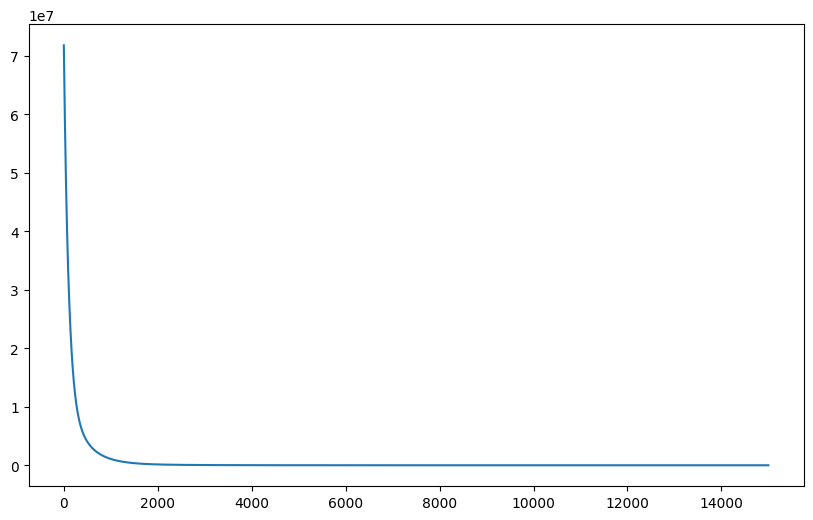

HMC starting.


sample: 100%|█| 12000/12000 [22:58<00:00,  8.71it/s, 1023 steps of size 5.08e-04. ac
/home/yanni/.cache/pypoetry/virtualenvs/grassgp-JZ6xTmeL-py3.10/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:329: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
 Omega_diag_chol[0]     28.99      8.29     27.10     17.84     42.10     47.59      1.05
 Omega_diag_chol[1]      6.46      1.47      6.30      3.94      8.65     25.01      1.00
 Omega_diag_chol[2]      0.58      0.34      0.51      0.10      1.08     17.08      1.08
 Omega_diag_chol[3]      1.36      0.31      1.30      0.90      1.83     45.40      1.03
 Omega_diag_chol[4]      0.91      0.22      0.86      0.55      1.23     44.42      1.00
 Omega_diag_chol[5]      0.55      0.12      0.53      0.38      0.72     48.73      1.02
 Omega_diag_chol[6]      0.38      0.10      0.37      0.23      0.52     47.92      1.03
 Omega_diag_chol[7]      0.28      0.09      0.27      0.16      0.40     54.32      1.00
 Omega_diag_chol[8]      0.19      0.06      0.18      0.09      0.28     86.83      1.00
 Omega_diag_chol[9]      0.14      0.05      0.13      0.06      0.21     81.74      1.00
Omega_dia

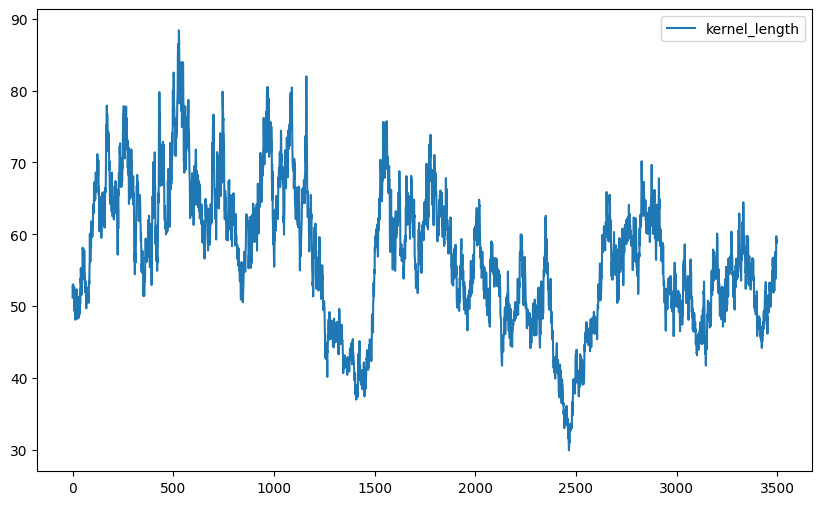

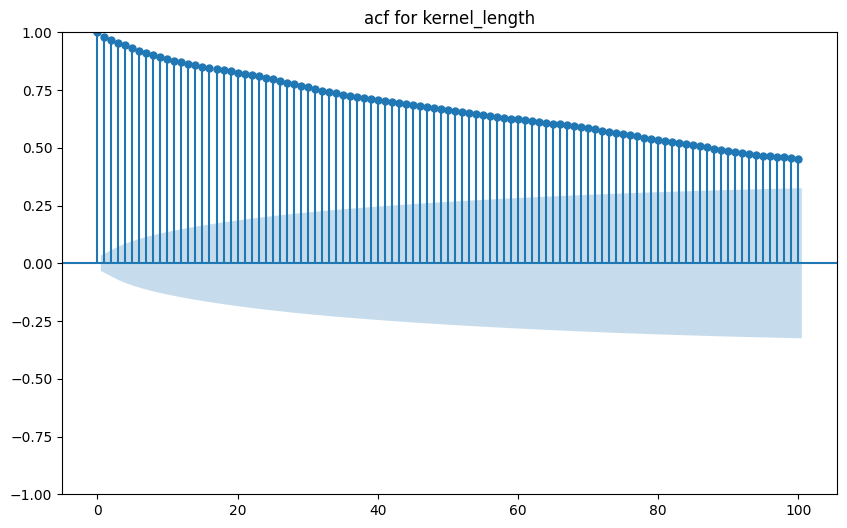

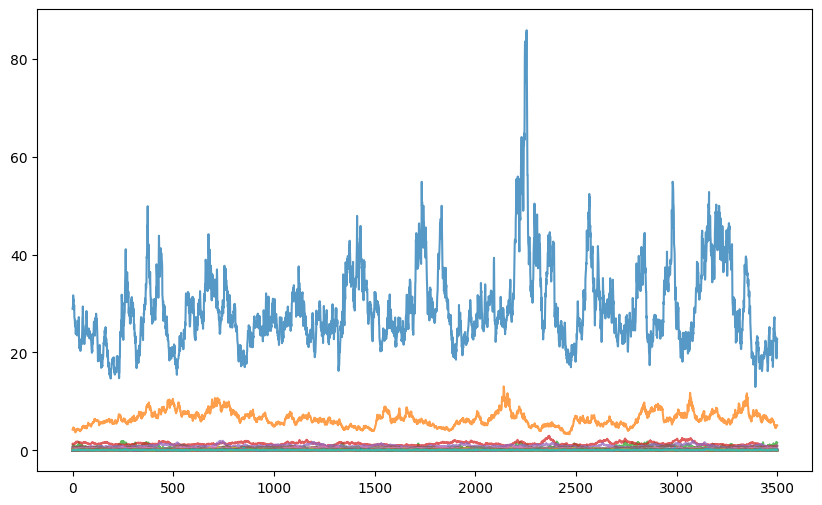

100%|███████████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]


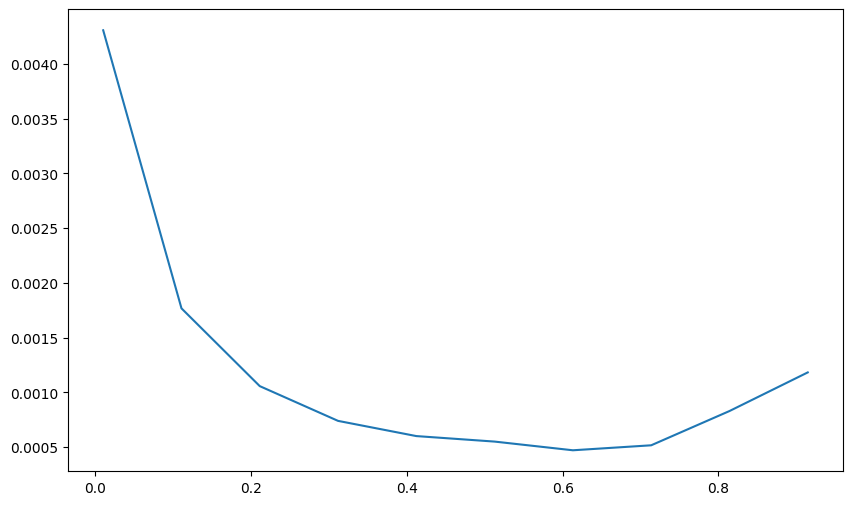

100%|███████████████████████████████████████████████| 10/10 [00:00<00:00, 60.29it/s]


Prediction starting


  0%|                                                      | 0/3500 [00:00<?, ?it/s]/home/yanni/.cache/pypoetry/virtualenvs/grassgp-JZ6xTmeL-py3.10/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:329: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(
  4%|█▋                                        | 139/3500 [03:45<1:31:03,  1.63s/it]

KeyboardInterrupt



In [50]:
(jobs,) = launch(
    Config,
    task_function,
    overrides=[
        "model.ell=0.001",
        "model.cov_jitter=0.0001"
    ],
    multirun=True,
)

In [ ]:
# Deltas_means = pickle_load("Deltas_means.pickle")
# Deltas_preds = pickle_load("Deltas_preds.pickle")

In [ ]:
# plt.rcParams["figure.figsize"] = (12,6)
# percentile_levels = [2.5, 97.5]
# conf_level = percentile_levels[-1] - percentile_levels[0]
# for i in range(10):
#     obs = log_Ws_train[:,i,0]
#     means = Deltas_means[:,:,i,0]
#     means_avg = np.mean(means, axis=0)
#     preds = Deltas_preds[:,:,i,0]
#     percentiles = np.percentile(preds, np.array(percentile_levels), axis=0)
#     lower = percentiles[0,:]
#     upper = percentiles[1,:]
#     plt.plot(s_test, log_Ws_test[:,i,0], label='full data',c='black', alpha=0.75, linestyle='dashed')
#     plt.scatter(s_train, log_Ws_train[:,i,0], label='training data', c='g')
#     plt.plot(s_test, means_avg, label='averaged mean prediction', c='r', alpha=0.75)
#     plt.fill_between(s_test, lower, upper, color='lightblue', alpha=0.75, label=f'{conf_level}% credible interval')
#     plt.xlabel(r"$s$")
#     plt.legend()
#     plt.vlines(s_train, 0.99*lower.min(), 1.01*upper.max(), colors='green', linestyles='dashed')
#     plt.title(f"{i+1}th component of tangents")
#     plt.ylim((-0.5,0.5))
#     plt.show()

In [ ]:
# plt.rcParams["figure.figsize"] = (12,6)
# percentile_levels = [2.5, 97.5]
# conf_level = percentile_levels[-1] - percentile_levels[0]
# for i in range(10):
#     obs = Ws_train[:,i,0]
#     means = Ws_means[:,:,i,0]
#     means_avg = np.mean(means, axis=0)
#     preds = Ws_preds[:,:,i,0]
#     percentiles = np.percentile(preds, np.array(percentile_levels), axis=0)
#     lower = percentiles[0,:]
#     upper = percentiles[1,:]
#     plt.plot(s_test, Ws_test[:,i,0], label='full data',c='black', alpha=0.75, linestyle='dashed')
#     plt.scatter(s_train, Ws_train[:,i,0], label='training data', c='g')
#     plt.plot(s_test, means_avg, label='averaged mean prediction', c='r', alpha=0.75)
#     plt.fill_between(s_test, lower, upper, color='lightblue', alpha=0.75, label=f'{conf_level}% credible interval')
#     plt.xlabel(r"$s$")
#     plt.legend()
#     plt.vlines(s_train, 0.99*lower.min(), 1.01*upper.max(), colors='green', linestyles='dashed')
#     plt.title(f"{i+1}th component of projections")
#     plt.ylim((-1,1))
#     plt.show()

In [ ]:
# in_sample_errors_df = pickle_load("in_sample_errors_df.pickle")

In [ ]:
# plt.plot(s_train,in_sample_errors_df['errors'])
# plt.show()

In [ ]:
# out_sample_errors_df = pickle_load("out_sample_errors_df.pickle")

In [ ]:
# out_sample_mean_errors = out_sample_errors_df["errors_mean"]
# out_sample_pred_errors = out_sample_errors_df["errors_pred"]
# sd_s_test_means = out_sample_errors_df["sd_mean"]
# sd_s_test_preds = out_sample_errors_df["sd_pred"]
# upper_mean = out_sample_mean_errors + sd_s_test_means
# upper_pred = out_sample_pred_errors + sd_s_test_preds

# fig = plt.figure(figsize=(12,6))
# ax = fig.add_subplot(111)
# ax.plot(s_test,out_sample_mean_errors, c='k', alpha=0.75, label='error using means')
# ax.plot(s_test,out_sample_pred_errors, c='b', alpha=0.75, label='error using preds')
# ax.vlines(s_train, 0, 0.1, colors="green", linestyles="dashed")
# ax.fill_between(s_test, np.array(out_sample_pred_errors), np.array(upper_pred), color='lightblue', alpha=0.75, label=f'error + 1 std using means')
# ax.fill_between(s_test, np.array(out_sample_mean_errors), np.array(upper_mean), color='coral', alpha=0.75, label=f'error + 1 std using preds')
# ax.set_xlabel(r"$s$")
# ax.legend()
# ax.grid()
# # fig.savefig('out-sample-error-plot.png',dpi=300,bbox_inches='tight',facecolor="w")
# plt.show()

In [ ]:
# plt.plot(s_test,out_sample_mean_errors, label='error using means')
# plt.plot(s_test,out_sample_pred_errors, label='error using preds')
# plt.vlines(s_train, 0, 0.1, colors="green", linestyles="dashed")
# plt.legend()
# plt.show()

In [ ]:
# cfg = Config
# # instantiate grass model
# model = instantiate(cfg.model).model

# save_results = cfg.save_results
# plot_figs = cfg.plots.plot
# save_stdout = cfg.save_stdout

# anchor_point = np.array(cfg.model.anchor_point)
# s_train = np.array(cfg.model.s_train)
# Ws_train = np.array(cfg.model.Ws_train)
# s_test = np.array(cfg.model.s_test)
# Ws_test = np.array(cfg.model.Ws_test)

# log_Ws_train = vmap(lambda W: grass_log(anchor_point, W))(Ws_train)
# log_Ws_test = vmap(lambda W: grass_log(anchor_point, W))(Ws_test)

# inference_data = pickle_load("inference_data.pickle")
# samples = dict(filter(lambda elem: 'initial_value' not in elem[0], inference_data.items()))
# initial_values = dict(filter(lambda elem: 'initial_value' in elem[0], inference_data.items()))
# assert set(samples.keys()).union(initial_values.keys()) == set(inference_data.keys())

# i=0
# percentile_levels = [2.5, 97.5]
# conf_level = percentile_levels[-1] - percentile_levels[0]
# in_preds = samples['Deltas'][:,:,i,0]
# percentiles = np.percentile(in_preds, np.array(percentile_levels), axis=0)
# lower = percentiles[0,:]
# upper = percentiles[1,:]
# plt.plot(s_test, log_Ws_test[:,i,0], label='full data',c='black', alpha=0.75, linestyle='dashed')
# plt.scatter(s_train, log_Ws_train[:,i,0], label='training data', c='g')
# plt.plot(s_train, samples['Deltas'].mean(axis=0)[:,i,0],c='red')
# plt.fill_between(s_train, lower, upper, color='lightblue', alpha=0.75, label=f'{conf_level}% credible interval')
# plt.show()